# Model - XGBoost Classifier

Overview of notebook, from Nature paper will classify each subreddit... etc.

> Modeling steps in this notebook
- TF-IDF Transform 
- Split data to training (80%) and testing (20%)
- To handle imbalanced class of our target variable we use SMOTE algorithm on the training data
- Use XGBoost Classifier 

##### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 

# Train, test, split
from sklearn.model_selection import train_test_split

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

# For classification
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from xgboost import plot_importance 

from sklearn.preprocessing import LabelEncoder 

##### Load data

In [2]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

##### Binarize targets using get_dummies

Will use each subreddit as target (except mental health)

In [3]:
posts = pd.get_dummies(posts, columns=['subreddit'])

In [4]:
posts.drop(columns='subreddit_mentalhealth', inplace = True)

## Vectorize using TFIDF
Implement Term Frequency - Inverse Document Frequency (TF-IDF) to vectorize the pre-processed text from the subreddit posts into numerical representations in a weight matrix that will be the basis for our set of feature for the predictive models. TF-IDF calculates how important a word is in a document in comparison to the entire corpus

In [5]:
# Remove stop words
X = posts['word_tokens']

In [6]:
# create the transform
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)

In [7]:
X = vectorizer.fit_transform(X)
vocab = vectorizer.get_feature_names()

In [8]:
df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

In [9]:
X = df

## Subreddit: Anorexia Nervosa

In [10]:
y = posts['subreddit_AnorexiaNervosa']

In [11]:
y.shape

(84879,)

### train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

Check that stratify worked as expected

In [13]:
sum(y_train)/len(y_train)

0.11388303904098493

In [14]:
sum(y_test)/len(y_test)

0.11386663524976437

Summarize the class distribution of the target

### Oversample the minority class using SMOTE

In [15]:
counter = Counter(y_train)
print(counter)

Counter({0: 60170, 1: 7733})


In [16]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [17]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60170, 1: 60170})


### XGBoost Model

Define Parameters for XGBoost Model

In [18]:
feature_names = X_train.columns

In [19]:
model = XGBClassifier(feature_names = feature_names,
                      n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 84, # stop at around 84 trees, model no loger improves much after
                      random_state = 42)

In [20]:
model.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:24:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.45966
[1]	validation_0-aucpr:0.47176
[2]	validation_0-aucpr:0.49701
[3]	validation_0-aucpr:0.50842
[4]	validation_0-aucpr:0.50727
[5]	validation_0-aucpr:0.52072
[6]	validation_0-aucpr:0.52649
[7]	validation_0-aucpr:0.53063
[8]	validation_0-aucpr:0.53176
[9]	validation_0-aucpr:0.53180
[10]	validation_0-aucpr:0.52959
[11]	validation_0-aucpr:0.53884
[12]	validation_0-aucpr:0.54862
[13]	validation_0-aucpr:0.54940
[14]	validation_0-aucpr:0.54779
[15]	validation_0-aucpr:0.54757
[16]	validation_0-aucpr:0.54341
[17]	validation_0-aucpr:0.55455
[18]	validation_0-aucpr:0.55307
[19]	validation_0-aucpr:0.55

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandoned', 'abandonment', 'ability', 'able', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'yeah', 'year', 'yelling', 'yes', 'yesterday', 'yet', 'young',
       'younger', 'youve', 'zero'],
      dtype='object', length=1500),
              gamma=0...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=84, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

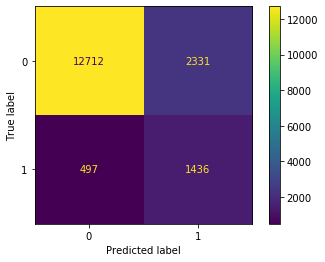

In [21]:
plot_confusion_matrix(model,
                      X_test,
                      y_test);

In [22]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.34%


In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90     15043
           1       0.38      0.74      0.50      1933

    accuracy                           0.83     16976
   macro avg       0.67      0.79      0.70     16976
weighted avg       0.90      0.83      0.85     16976



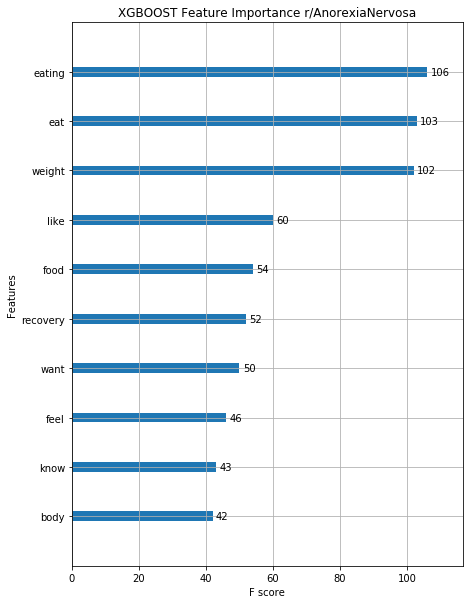

In [24]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model,max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance r/AnorexiaNervosa")
plt.savefig('../images/anorexia_reddit.png');

## Subreddit: Anxiety

In [25]:
y = posts['subreddit_Anxiety']

In [26]:
y.shape

(84879,)

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

In [28]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 60342, 1: 7561})


In [29]:
# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [30]:
# summarize class distribution
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({1: 60342, 0: 60342})


In [31]:
feature_names = X_train.columns

In [32]:
model2 = XGBClassifier(feature_names = feature_names,
                       n_classes = 2, 
                       missing=None,
                       objective='binary:logistic',
                       use_label_encoder = False,
                       n_jobs = 4,
                       subsample = .8,
                       n_estimators = 14, # stop at around 14? trees, model no loger improves much after
                       random_state = 42)

In [33]:
model2.fit(X_train_sm, 
           y_train_sm,
           verbose = True, # set to true if you want to see where to stop early
           early_stopping_rounds = 10, # reduce overfitting with early stopping
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:28:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { feature_names, n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.21528
[1]	validation_0-aucpr:0.22022
[2]	validation_0-aucpr:0.22696
[3]	validation_0-aucpr:0.22997
[4]	validation_0-aucpr:0.23986
[5]	validation_0-aucpr:0.24363
[6]	validation_0-aucpr:0.24213
[7]	validation_0-aucpr:0.24501
[8]	validation_0-aucpr:0.24662
[9]	validation_0-aucpr:0.24896
[10]	validation_0-aucpr:0.24372
[11]	validation_0-aucpr:0.24899
[12]	validation_0-aucpr:0.24626
[13]	validation_0-aucpr:0.24624


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              feature_names=Index(['abandoned', 'abandonment', 'ability', 'able', 'absolute', 'absolutely',
       'abuse', 'abusive', 'accept', 'accepted',
       ...
       'yeah', 'year', 'yelling', 'yes', 'yesterday', 'yet', 'young',
       'younger', 'youve', 'zero'],
      dtype='object', length=1500),
              gamma=0...
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              monotone_constraints='()', n_classes=2, n_estimators=14, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

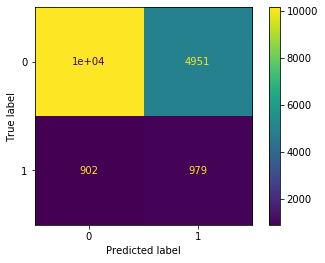

In [34]:
plot_confusion_matrix(model2,
                      X_test,
                      y_test);

In [35]:
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.52%


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     15095
           1       0.17      0.52      0.25      1881

    accuracy                           0.66     16976
   macro avg       0.54      0.60      0.51     16976
weighted avg       0.83      0.66      0.72     16976



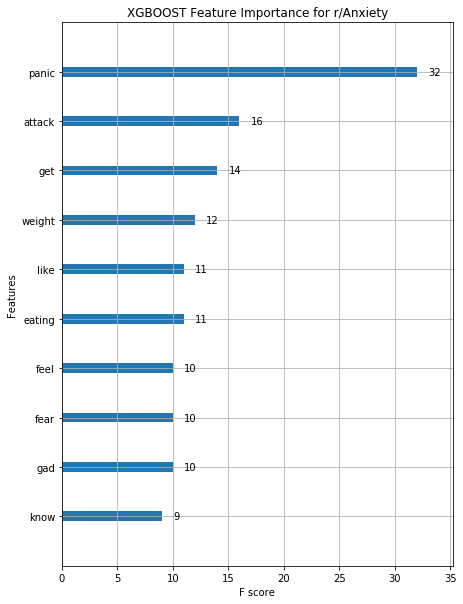

In [37]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model2, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Anxiety")
plt.savefig('../images/anxiety_reddit.png')

## Subreddit: Autism

In [38]:
y = posts['subreddit_autism']

In [39]:
y.shape

(84879,)

### train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [41]:
counter = Counter(y_train)
print(counter)

Counter({0: 60547, 1: 7356})


### Oversample the minority class using SMOTE

In [42]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [43]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60547, 1: 60547})


### XGBoost Model

Define Parameters for XGBoost Model

In [44]:
model3 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 222, # stop at around 222 trees, model no loger improves much after
                      random_state = 42)

In [45]:
model3.fit(X_train_sm, 
          y_train_sm,
          verbose = False, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:29:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=222, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

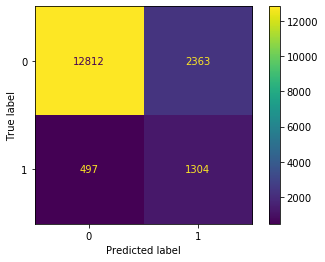

In [46]:
plot_confusion_matrix(model3,
                      X_test,
                      y_test);

In [47]:
y_pred = model3.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.15%


In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     15175
           1       0.36      0.72      0.48      1801

    accuracy                           0.83     16976
   macro avg       0.66      0.78      0.69     16976
weighted avg       0.90      0.83      0.85     16976



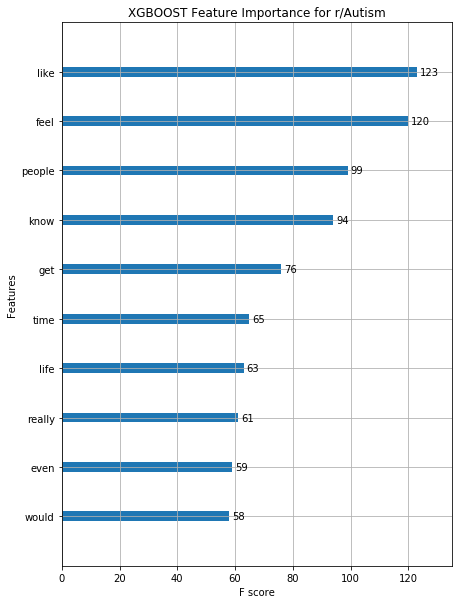

In [49]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model3, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/Autism")
plt.savefig('../images/autism_reddit.png')
#plt.show();

## Subreddit: BPD

In [50]:
y = posts['subreddit_BPD']

In [51]:
y.shape

(84879,)

### train test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [53]:
counter = Counter(y_train)
print(counter)

Counter({0: 60474, 1: 7429})


### Oversample the minority class using SMOTE

In [54]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [55]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60474, 1: 60474})


### XGBoost Model

Define Parameters for XGBoost Model

In [56]:
model4 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 200, # stop at around n trees, model no loger improves much after
                      random_state = 42)

In [57]:
model4.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:36:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.15190
[1]	validation_0-aucpr:0.16003
[2]	validation_0-aucpr:0.16366
[3]	validation_0-aucpr:0.17979
[4]	validation_0-aucpr:0.17454
[5]	validation_0-aucpr:0.17960
[6]	validation_0-aucpr:0.18732
[7]	validation_0-aucpr:0.18802
[8]	validation_0-aucpr:0.19541
[9]	validation_0-aucpr:0.21004
[10]	validation_0-aucpr:0.22416
[11]	validation_0-aucpr:0.22348
[12]	validation_0-aucpr:0.21863
[13]	validation_0-aucpr:0.22224
[14]	validation_0-aucpr:0.22138
[15]	validation_0-aucpr:0.22406
[16]	validation_0-aucpr:0.23106
[17]	validation_0-aucpr:0.23118
[18]	validation_0-aucpr:0.22814
[19]	validation_0-aucpr:0.22386
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=200, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [58]:
y_pred = model4.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.77%


In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.75      0.82     15070
           1       0.19      0.48      0.28      1906

    accuracy                           0.72     16976
   macro avg       0.56      0.62      0.55     16976
weighted avg       0.84      0.72      0.76     16976



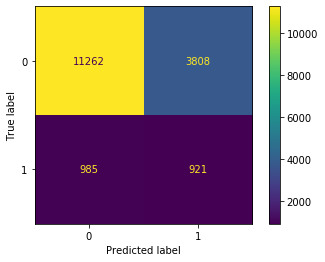

In [60]:
plot_confusion_matrix(model4,
                      X_test,
                      y_test);

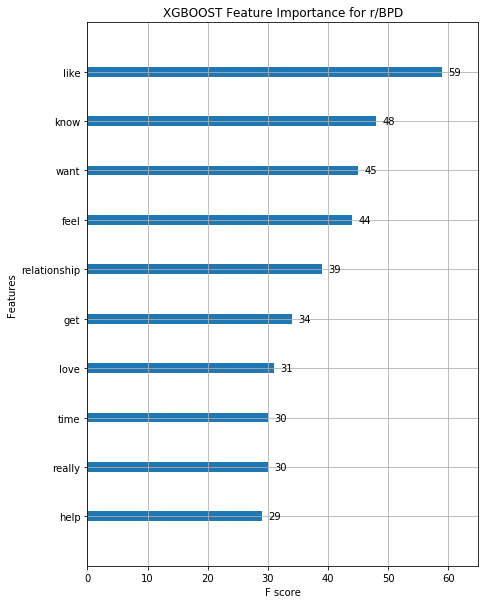

In [61]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model4, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/BPD")
plt.savefig('../images/BPD_reddit.png')
#plt.show();

## Subreddit: Bipolar

In [62]:
y = posts['subreddit_bipolar']

In [63]:
y.shape

(84879,)

### train test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [65]:
counter = Counter(y_train)
print(counter)

Counter({0: 60448, 1: 7455})


### Oversample the minority class using SMOTE

In [66]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [67]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60448, 1: 60448})


### XGBoost Model

Define Parameters for XGBoost Model

In [68]:
model5 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 33, # stop at around 33 trees, model no loger improves much after
                      random_state = 42)

In [69]:
model5.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:40:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.25791
[1]	validation_0-aucpr:0.26726
[2]	validation_0-aucpr:0.31912
[3]	validation_0-aucpr:0.32682
[4]	validation_0-aucpr:0.32814
[5]	validation_0-aucpr:0.33569
[6]	validation_0-aucpr:0.34062
[7]	validation_0-aucpr:0.35656
[8]	validation_0-aucpr:0.35316
[9]	validation_0-aucpr:0.35579
[10]	validation_0-aucpr:0.36869
[11]	validation_0-aucpr:0.37302
[12]	validation_0-aucpr:0.37442
[13]	validation_0-aucpr:0.37702
[14]	validation_0-aucpr:0.38499
[15]	validation_0-aucpr:0.38665
[16]	validation_0-aucpr:0.39304
[17]	validation_0-aucpr:0.39336
[18]	validation_0-aucpr:0.39155
[19]	validation_0-aucpr:0.39575
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=33, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [70]:
y_pred = model5.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.25%


In [71]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82     15042
           1       0.23      0.63      0.34      1934

    accuracy                           0.72     16976
   macro avg       0.59      0.68      0.58     16976
weighted avg       0.86      0.72      0.77     16976



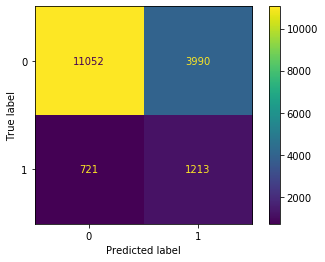

In [72]:
plot_confusion_matrix(model5,
                      X_test,
                      y_test);

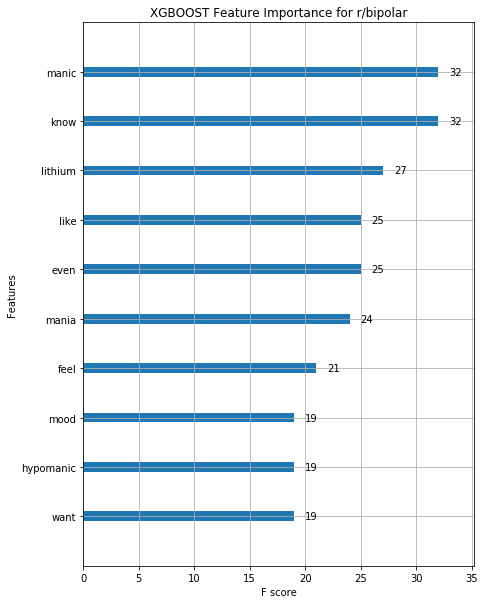

In [73]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model5, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/bipolar")
plt.savefig('../images/bipolar_reddit.png')
#plt.show();

## Subreddit: Bulimia

In [74]:
y = posts['subreddit_bulimia']

In [75]:
y.shape

(84879,)

### train test split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [77]:
counter = Counter(y_train)
print(counter)

Counter({0: 60031, 1: 7872})


### Oversample the minority class using SMOTE

In [78]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [79]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60031, 1: 60031})


### XGBoost Model

Define Parameters for XGBoost Model

In [80]:
model6 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 36, # stop at around 36 trees, model no loger improves much after
                      random_state = 42)

In [81]:
model6.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:41:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.55818
[1]	validation_0-aucpr:0.57974
[2]	validation_0-aucpr:0.59806
[3]	validation_0-aucpr:0.59671
[4]	validation_0-aucpr:0.60011
[5]	validation_0-aucpr:0.59775
[6]	validation_0-aucpr:0.60454
[7]	validation_0-aucpr:0.60305
[8]	validation_0-aucpr:0.60533
[9]	validation_0-aucpr:0.60739
[10]	validation_0-aucpr:0.60557
[11]	validation_0-aucpr:0.61206
[12]	validation_0-aucpr:0.62372
[13]	validation_0-aucpr:0.62198
[14]	validation_0-aucpr:0.62233
[15]	validation_0-aucpr:0.62569
[16]	validation_0-aucpr:0.62580
[17]	validation_0-aucpr:0.62567
[18]	validation_0-aucpr:0.62570
[19]	validation_0-aucpr:0.62682
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=36, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [82]:
y_pred = model6.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.21%


In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     15102
           1       0.31      0.73      0.44      1874

    accuracy                           0.79     16976
   macro avg       0.64      0.76      0.65     16976
weighted avg       0.89      0.79      0.82     16976



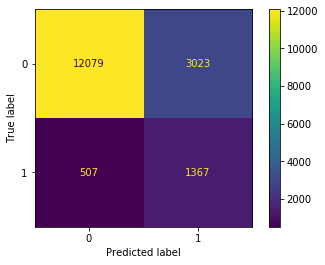

In [84]:
plot_confusion_matrix(model6,
                      X_test,
                      y_test);

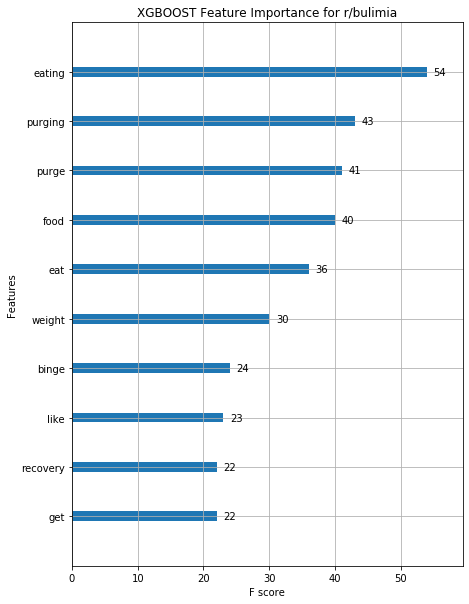

In [85]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model6, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/bulimia")
plt.savefig('../images/bulimia_reddit.png')

## Subreddit: Depression

In [86]:
y = posts['subreddit_depression']

In [87]:
y.shape

(84879,)

### train test split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [89]:
counter = Counter(y_train)
print(counter)

Counter({0: 60507, 1: 7396})


### Oversample the minority class using SMOTE

In [90]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [91]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60507, 1: 60507})


### XGBoost Model

Define Parameters for XGBoost Model

In [92]:
model7 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 100, # stop at around 100 trees, model no loger improves much after
                      random_state = 42)

In [93]:
model7.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:43:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.14873
[1]	validation_0-aucpr:0.15030
[2]	validation_0-aucpr:0.15301
[3]	validation_0-aucpr:0.15770
[4]	validation_0-aucpr:0.16232
[5]	validation_0-aucpr:0.19162
[6]	validation_0-aucpr:0.19153
[7]	validation_0-aucpr:0.20193
[8]	validation_0-aucpr:0.20117
[9]	validation_0-aucpr:0.20132
[10]	validation_0-aucpr:0.20769
[11]	validation_0-aucpr:0.21019
[12]	validation_0-aucpr:0.21121
[13]	validation_0-aucpr:0.21160
[14]	validation_0-aucpr:0.21624
[15]	validation_0-aucpr:0.22420
[16]	validation_0-aucpr:0.22151
[17]	validation_0-aucpr:0.22673
[18]	validation_0-aucpr:0.22398
[19]	validation_0-aucpr:0.22472
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [94]:
y_pred = model7.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.24%


In [95]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84     15055
           1       0.23      0.53      0.32      1921

    accuracy                           0.74     16976
   macro avg       0.58      0.65      0.58     16976
weighted avg       0.85      0.74      0.78     16976



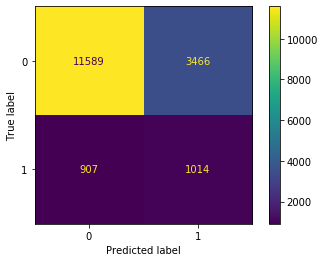

In [96]:
plot_confusion_matrix(model7,
                      X_test,
                      y_test);

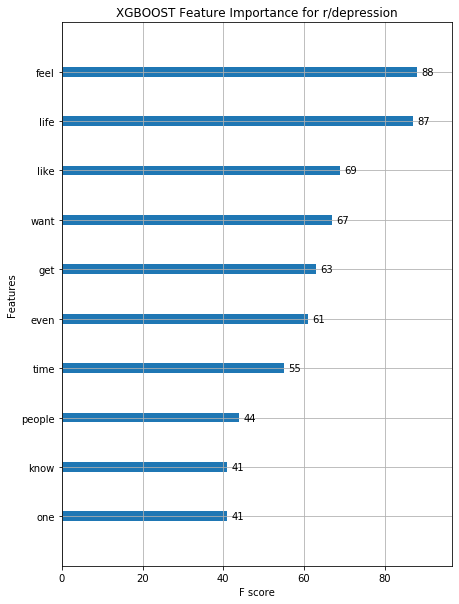

In [97]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model7, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/depression")
plt.savefig('../images/depression_reddit.png')

## Subreddit: Schizophrenia

In [98]:
y = posts['subreddit_schizophrenia']

In [99]:
y.shape

(84879,)

### train test split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state=42)

Summarize the class distribution of the target

In [101]:
counter = Counter(y_train)
print(counter)

Counter({0: 60303, 1: 7600})


### Oversample the minority class using SMOTE

In [102]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Summarize the class distribution of the target after oversampling the minority class using the SMOTE algorithm.

In [103]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

Counter({0: 60303, 1: 60303})


### XGBoost Model

Define Parameters for XGBoost Model

In [104]:
model8 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 66, # stop at around 66 trees, model no loger improves much after
                      random_state = 42)

In [105]:
model8.fit(X_train_sm, 
          y_train_sm,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:48:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.19487
[1]	validation_0-aucpr:0.19929
[2]	validation_0-aucpr:0.20391
[3]	validation_0-aucpr:0.20847
[4]	validation_0-aucpr:0.21707
[5]	validation_0-aucpr:0.22356
[6]	validation_0-aucpr:0.22351
[7]	validation_0-aucpr:0.22215
[8]	validation_0-aucpr:0.22445
[9]	validation_0-aucpr:0.22590
[10]	validation_0-aucpr:0.22749
[11]	validation_0-aucpr:0.22990
[12]	validation_0-aucpr:0.25057
[13]	validation_0-aucpr:0.25043
[14]	validation_0-aucpr:0.25231
[15]	validation_0-aucpr:0.25240
[16]	validation_0-aucpr:0.25192
[17]	validation_0-aucpr:0.25369
[18]	validation_0-aucpr:0.25328
[19]	validation_0-aucpr:0.25859
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=66, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [106]:
y_pred = model8.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.83%


In [107]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87     15171
           1       0.26      0.60      0.37      1805

    accuracy                           0.78     16976
   macro avg       0.60      0.70      0.62     16976
weighted avg       0.87      0.78      0.81     16976



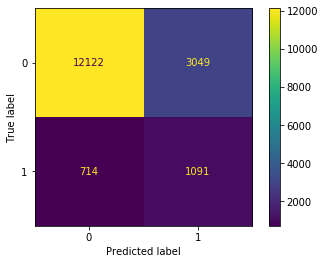

In [108]:
plot_confusion_matrix(model8,
                      X_test,
                      y_test);

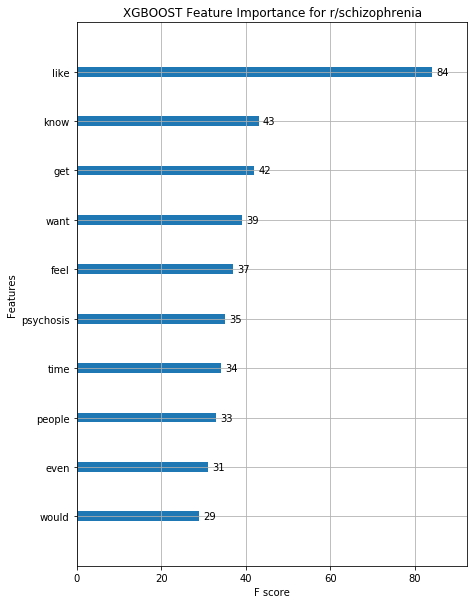

In [109]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model8, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for r/schizophrenia")
plt.savefig('../images/schizophrenia_reddit.png')

# Pre and post Covid

##### Binarize targets using get_dummies

In [110]:
#posts = 
posts = pd.get_dummies(posts, columns=['timeframe'], drop_first=True)

In [111]:
y = posts['timeframe_pre-covid']

In [112]:
y.shape

(84879,)

### train test split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

Check that stratify worked as expected

In [114]:
sum(y_train)/len(y_train)

0.4942933301915968

In [115]:
sum(y_test)/len(y_test)

0.4942860508953817

Summarize the class distribution of the target

In [116]:
counter = Counter(y_train)
print(counter)

Counter({0: 34339, 1: 33564})


### XGBoost Model

In [117]:
model9 = XGBClassifier(n_classes = 2, 
                      missing=None,
                      objective='binary:logistic',
                      use_label_encoder = False,
                      n_jobs = 4,
                      subsample = .8,
                      n_estimators = 35, # stop at around 35 trees, model no loger improves much after
                      random_state = 42)

In [118]:
model9.fit(X_train, 
          y_train,
          verbose = True, # set to true if you want to see where to stop early
          early_stopping_rounds = 10, # reduce overfitting with early stopping
          eval_metric = 'aucpr',
          eval_set = [(X_test, y_test)]) # helps determine how many trees to build

[23:51:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.55117
[1]	validation_0-aucpr:0.55854
[2]	validation_0-aucpr:0.56420
[3]	validation_0-aucpr:0.57154
[4]	validation_0-aucpr:0.57667
[5]	validation_0-aucpr:0.58222
[6]	validation_0-aucpr:0.58710
[7]	validation_0-aucpr:0.58870
[8]	validation_0-aucpr:0.58969
[9]	validation_0-aucpr:0.59190
[10]	validation_0-aucpr:0.59297
[11]	validation_0-aucpr:0.59263
[12]	validation_0-aucpr:0.59201
[13]	validation_0-aucpr:0.59596
[14]	validation_0-aucpr:0.59664
[15]	validation_0-aucpr:0.59950
[16]	validation_0-aucpr:0.59969
[17]	validation_0-aucpr:0.60036
[18]	validation_0-aucpr:0.60188
[19]	validation_0-aucpr:0.60184
[20]	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_classes=2, n_estimators=35, n_jobs=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [119]:
y_pred = model9.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.65%


In [120]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.47      0.53      8585
           1       0.57      0.71      0.63      8391

    accuracy                           0.59     16976
   macro avg       0.59      0.59      0.58     16976
weighted avg       0.59      0.59      0.58     16976



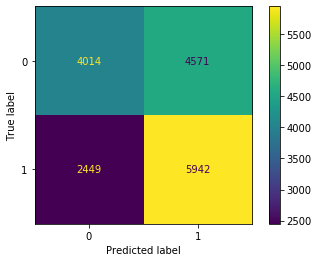

In [121]:
plot_confusion_matrix(model9,
                      X_test,
                      y_test);

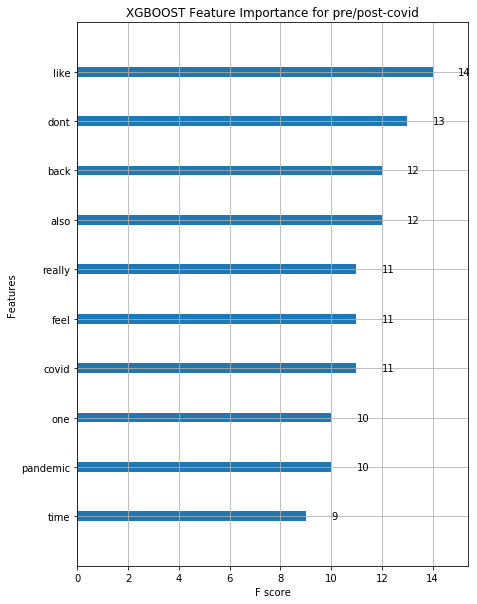

In [122]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model9, max_num_features=10,ax=ax)
plt.title("XGBOOST Feature Importance for pre/post-covid")
plt.savefig('../images/precovid_reddit.png')

# Try XGBoost with all classes in model

In [123]:
# reload data
multi_class_df = pd.read_csv('../data/posts-preprocessed.csv')

In [124]:
multi_class_df.head(1)

,author,created_utc,subreddit,timeframe,text_clean,sent_tokens,word_tokens
0,sub30605,1499390694,bulimia,pre-covid,chest anyone else experience chest purging kno...,['chest anyone else experience chest purging k...,"['chest', 'anyone', 'else', 'experience', 'che..."


In [125]:
multi_class_df['subreddit'].value_counts()

bulimia            9746
AnorexiaNervosa    9666
Anxiety            9442
mentalhealth       9422
schizophrenia      9405
bipolar            9389
BPD                9335
depression         9317
autism             9157
Name: subreddit, dtype: int64

In [126]:
lc = LabelEncoder() 

In [127]:
y = multi_class_df['subreddit']

In [128]:
lc = lc.fit(y) 

In [129]:
lc_y = lc.transform(y)

In [130]:
# Try doing this in another notebook as to redo X... 
X = df

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, lc_y,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

In [132]:
counter = Counter(y_train)
print(counter)

Counter({5: 7797, 0: 7733, 1: 7553, 7: 7537, 8: 7524, 4: 7511, 2: 7468, 6: 7454, 3: 7326})


In [133]:
model_multi_class = XGBClassifier(objective='multi:softprob',
                                  use_label_encoder = False,
                                  n_jobs = 4,
                                  subsample = .8,
                                  n_estimators = 100, 
                                  random_state = 42) 

In [134]:
print(model_multi_class)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              objective='multi:softprob', random_state=42, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=0.8,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None)


In [135]:
model_multi_class.fit(X_train, 
                      y_train,
                      verbose = True)

[23:53:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [136]:
y_pred = model_multi_class.predict(X_test) 

predictions = [round(value) for value in y_pred]

In [137]:
accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 51.56%


In [138]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      1933
           1       0.50      0.48      0.49      1889
           2       0.50      0.44      0.47      1867
           3       0.42      0.72      0.53      1831
           4       0.63      0.40      0.49      1878
           5       0.79      0.63      0.70      1949
           6       0.44      0.49      0.46      1863
           7       0.39      0.32      0.35      1885
           8       0.42      0.47      0.45      1881

    accuracy                           0.52     16976
   macro avg       0.53      0.52      0.51     16976
weighted avg       0.53      0.52      0.52     16976

